In [1]:
"""
================================================================================
CREDIT CARD DEFAULT PREDICTION - OPTIMIZED PIPELINE
================================================================================
A clean, efficient approach focusing on what actually works
- Smart preprocessing
- Selective feature engineering
- Proper scaling
- Multiple models with threshold optimization
================================================================================
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Sklearn imports
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, precision_recall_curve, recall_score,
                             precision_score, f1_score, make_scorer)

# Advanced models
try:
    import xgboost as xgb
    import lightgbm as lgb
    ADVANCED_MODELS_AVAILABLE = True
except:
    print("  XGBoost/LightGBM not installed. Install with: pip install xgboost lightgbm")
    ADVANCED_MODELS_AVAILABLE = False

print("="*80)
print("CREDIT CARD DEFAULT PREDICTION - OPTIMIZED PIPELINE")
print("="*80)

import kagglehub

# Download latest version
path = kagglehub.dataset_download("uciml/default-of-credit-card-clients-dataset")

print("Path to dataset files:", path)

import os

print(os.listdir(path))

uci = pd.read_csv(os.path.join(path, 'UCI_Credit_Card.csv'))
df = uci.copy()

print(f"\nInitial shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

CREDIT CARD DEFAULT PREDICTION - OPTIMIZED PIPELINE
Using Colab cache for faster access to the 'default-of-credit-card-clients-dataset' dataset.
Path to dataset files: /kaggle/input/default-of-credit-card-clients-dataset
['UCI_Credit_Card.csv']

Initial shape: (30000, 25)
Columns: ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default.payment.next.month']


In [2]:
# ============================================================================
# STEP 2: INITIAL DATA QUALITY CHECKS
# ============================================================================
print("\n" + "="*80)
print("STEP 2: DATA QUALITY CHECKS")
print("="*80)

# Check duplicates
dup_count = df.duplicated().sum()
print(f"\n Duplicates: {dup_count}")

# Check missing values
missing = df.isnull().sum().sum()
print(f" Missing values: {missing}")

# Check target distribution
target_dist = df['default.payment.next.month'].value_counts()
print(f"\n Target distribution:")
print(f"  No Default (0): {target_dist[0]:,} ({target_dist[0]/len(df)*100:.2f}%)")
print(f"  Default (1): {target_dist[1]:,} ({target_dist[1]/len(df)*100:.2f}%)")
print(f"  Imbalance ratio: {target_dist[0]/target_dist[1]:.2f}:1")


# ============================================================================
# STEP 3: DATA CLEANING
# ============================================================================
print("\n" + "="*80)
print("STEP 3: DATA CLEANING")
print("="*80)

df_clean = df.copy()

# 3.1: Fix invalid categorical codes
print("\n3.1: Fixing Invalid Categorical Codes")
print("-" * 60)

# EDUCATION: 0,5,6 are undocumented -> recode to 4 (Others)
invalid_edu = df_clean['EDUCATION'].isin([0, 5, 6]).sum()
print(f"  • EDUCATION: Recoding {invalid_edu} invalid values (0,5,6) → 4 (Others)")
df_clean['EDUCATION'] = df_clean['EDUCATION'].replace([0, 5, 6], 4)

# MARRIAGE: 0 is undocumented -> recode to 3 (Others)
invalid_mar = (df_clean['MARRIAGE'] == 0).sum()
print(f"  • MARRIAGE: Recoding {invalid_mar} invalid values (0) → 3 (Others)")
df_clean['MARRIAGE'] = df_clean['MARRIAGE'].replace(0, 3)

# 3.2: Rename columns for clarity
print("\n3.2: Renaming Columns")
print("-" * 60)
df_clean = df_clean.rename(columns={'default.payment.next.month': 'default'})
print("   Renamed 'default.payment.next.month' → 'default'")

# 3.3: Remove outliers (CRITICAL IMPROVEMENT!)
print("\n3.3: Removing Outliers (IQR Method)")
print("-" * 60)

initial_rows = len(df_clean)

# Remove AGE outliers
q1_age = df_clean['AGE'].quantile(0.25)
q3_age = df_clean['AGE'].quantile(0.75)
iqr_age = q3_age - q1_age
age_lower = q1_age - 1.5 * iqr_age
age_upper = q3_age + 1.5 * iqr_age
df_clean = df_clean[(df_clean['AGE'] >= age_lower) & (df_clean['AGE'] <= age_upper)]
age_removed = initial_rows - len(df_clean)
print(f"  • AGE: Removed {age_removed} outliers (range: [{age_lower:.0f}, {age_upper:.0f}])")

# Remove LIMIT_BAL outliers
initial_rows = len(df_clean)
q1_limit = df_clean['LIMIT_BAL'].quantile(0.25)
q3_limit = df_clean['LIMIT_BAL'].quantile(0.75)
iqr_limit = q3_limit - q1_limit
limit_lower = q1_limit - 1.5 * iqr_limit
limit_upper = q3_limit + 1.5 * iqr_limit
df_clean = df_clean[(df_clean['LIMIT_BAL'] >= limit_lower) & (df_clean['LIMIT_BAL'] <= limit_upper)]
limit_removed = initial_rows - len(df_clean)
print(f"  • LIMIT_BAL: Removed {limit_removed} outliers (range: [{limit_lower:,.0f}, {limit_upper:,.0f}])")

print(f"\n Final shape after cleaning: {df_clean.shape}")
print(f" Rows removed: {df.shape[0] - df_clean.shape[0]} ({(df.shape[0] - df_clean.shape[0])/df.shape[0]*100:.2f}%)")



STEP 2: DATA QUALITY CHECKS

 Duplicates: 0
 Missing values: 0

 Target distribution:
  No Default (0): 23,364 (77.88%)
  Default (1): 6,636 (22.12%)
  Imbalance ratio: 3.52:1

STEP 3: DATA CLEANING

3.1: Fixing Invalid Categorical Codes
------------------------------------------------------------
  • EDUCATION: Recoding 345 invalid values (0,5,6) → 4 (Others)
  • MARRIAGE: Recoding 54 invalid values (0) → 3 (Others)

3.2: Renaming Columns
------------------------------------------------------------
   Renamed 'default.payment.next.month' → 'default'

3.3: Removing Outliers (IQR Method)
------------------------------------------------------------
  • AGE: Removed 272 outliers (range: [8, 60])
  • LIMIT_BAL: Removed 164 outliers (range: [-235,000, 525,000])

 Final shape after cleaning: (29564, 25)
 Rows removed: 436 (1.45%)


In [3]:
# ============================================================================
# STEP 4: SMART FEATURE ENGINEERING (ONLY HIGH-VALUE FEATURES)
# ============================================================================
print("\n" + "="*80)
print("STEP 4: SELECTIVE FEATURE ENGINEERING")
print("="*80)

df_fe = df_clean.copy()

# Define column groups
pay_cols = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
bill_cols = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
pay_amt_cols = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

print("\n4.1: Utilization Features (Critical for Credit Risk)")
print("-" * 60)

# Current utilization (most important)
df_fe['utilization_current'] = df_fe['BILL_AMT1'] / (df_fe['LIMIT_BAL'] + 1)

# Average utilization over 6 months
df_fe['utilization_avg'] = df_fe[bill_cols].mean(axis=1) / (df_fe['LIMIT_BAL'] + 1)

# Maximum utilization (peak usage)
df_fe['utilization_max'] = df_fe[bill_cols].max(axis=1) / (df_fe['LIMIT_BAL'] + 1)

print("   Created: utilization_current, utilization_avg, utilization_max")

print("\n4.2: Payment Behavior Features (Strongest Predictors)")
print("-" * 60)

# Maximum delay across all months
df_fe['max_delay'] = df_fe[pay_cols].max(axis=1)

# Number of months with delays
df_fe['num_months_delayed'] = (df_fe[pay_cols] > 0).sum(axis=1)

# Severe delay indicator
df_fe['severe_delay'] = (df_fe['PAY_0'] >= 2).astype(int)

# Chronic delayer (4+ months of delays)
df_fe['chronic_delayer'] = (df_fe['num_months_delayed'] >= 4).astype(int)

# Recent payment worsening
df_fe['payment_worsening'] = (df_fe['PAY_0'] > df_fe['PAY_6']).astype(int)

print("   Created: max_delay, num_months_delayed, severe_delay")
print("   Created: chronic_delayer, payment_worsening")

print("\n4.3: Payment Amount Features")
print("-" * 60)

# Average payment
df_fe['avg_payment'] = df_fe[pay_amt_cols].mean(axis=1)

# Number of zero payments
df_fe['num_zero_payments'] = (df_fe[pay_amt_cols] == 0).sum(axis=1)

print("   Created: avg_payment, num_zero_payments")

print("\n4.4: Payment-to-Bill Ratios (High Predictive Power)")
print("-" * 60)

# Current payment ratio
df_fe['payment_ratio_current'] = df_fe['PAY_AMT1'] / (df_fe['BILL_AMT1'].abs() + 1)

# Under-paying indicator
df_fe['underpaying'] = (df_fe['payment_ratio_current'] < 0.1).astype(int)

print("   Created: payment_ratio_current, underpaying")

print("\n4.5: Bill Amount Features")
print("-" * 60)

# Average bill
df_fe['avg_bill'] = df_fe[bill_cols].mean(axis=1)

# Bill increasing trend
df_fe['bill_increasing'] = (df_fe['BILL_AMT1'] > df_fe['BILL_AMT6']).astype(int)

print("   Created: avg_bill, bill_increasing")

print("\n4.6: High-Value Composite Features")
print("-" * 60)

# Red flag count (composite risk indicator)
df_fe['red_flag_count'] = (
    (df_fe['utilization_current'] > 0.9).astype(int) +
    (df_fe['severe_delay']).astype(int) +
    (df_fe['chronic_delayer']).astype(int) +
    (df_fe['underpaying']).astype(int) +
    (df_fe['num_zero_payments'] >= 3).astype(int)
)

# Limit per age (creditworthiness proxy)
df_fe['limit_per_age'] = df_fe['LIMIT_BAL'] / (df_fe['AGE'] + 1)

# High utilization with delays (dangerous combo)
df_fe['high_util_delayed'] = (
    (df_fe['utilization_current'] > 0.7) &
    (df_fe['num_months_delayed'] >= 2)
).astype(int)

print("   Created: red_flag_count, limit_per_age, high_util_delayed")

# Clean any inf/nan from divisions
numeric_cols = df_fe.select_dtypes(include=[np.number]).columns
df_fe[numeric_cols] = df_fe[numeric_cols].replace([np.inf, -np.inf], np.nan)
df_fe[numeric_cols] = df_fe[numeric_cols].fillna(0)

print(f"\n Total features: {df_fe.shape[1]}")
print(f"  • Original features: {df_clean.shape[1]}")
print(f"  • Engineered features: {df_fe.shape[1] - df_clean.shape[1]}")



STEP 4: SELECTIVE FEATURE ENGINEERING

4.1: Utilization Features (Critical for Credit Risk)
------------------------------------------------------------
   Created: utilization_current, utilization_avg, utilization_max

4.2: Payment Behavior Features (Strongest Predictors)
------------------------------------------------------------
   Created: max_delay, num_months_delayed, severe_delay
   Created: chronic_delayer, payment_worsening

4.3: Payment Amount Features
------------------------------------------------------------
   Created: avg_payment, num_zero_payments

4.4: Payment-to-Bill Ratios (High Predictive Power)
------------------------------------------------------------
   Created: payment_ratio_current, underpaying

4.5: Bill Amount Features
------------------------------------------------------------
   Created: avg_bill, bill_increasing

4.6: High-Value Composite Features
------------------------------------------------------------
   Created: red_flag_count, limit_per_age, 

In [4]:
# ============================================================================
# STEP 5: SMART FEATURE SELECTION (KEEP ONLY VALUABLE FEATURES)
# ============================================================================
print("\n" + "="*80)
print("STEP 5: FEATURE SELECTION")
print("="*80)

# Features to KEEP
features_to_keep = [
    # Target
    'default',

    # Core demographic features (KEEP ALL)
    'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',

    # Payment status features (KEEP ALL - most important!)
    'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',

    # Keep only FIRST bill and payment amounts (most recent = most important)
    'BILL_AMT1', 'PAY_AMT1',

    # Engineered features (ONLY the best ones)
    'utilization_current', 'utilization_avg', 'utilization_max',
    'max_delay', 'num_months_delayed', 'severe_delay', 'chronic_delayer',
    'payment_worsening', 'avg_payment', 'num_zero_payments',
    'payment_ratio_current', 'underpaying',
    'avg_bill', 'bill_increasing',
    'red_flag_count', 'limit_per_age', 'high_util_delayed'
]

# Create final dataset
df_final = df_fe[features_to_keep].copy()

print(f"\n Selected {len(features_to_keep)-1} features (+ target)")
print(f" Final dataset shape: {df_final.shape}")

# Drop ID if it exists
if 'ID' in df_final.columns:
    df_final = df_final.drop('ID', axis=1)


STEP 5: FEATURE SELECTION

 Selected 30 features (+ target)
 Final dataset shape: (29564, 31)


In [5]:
# ============================================================================
# STEP 6: SMART SCALING (ONLY CONTINUOUS FEATURES)
# ============================================================================
print("\n" + "="*80)
print("STEP 6: SMART FEATURE SCALING")
print("="*80)

# Separate features and target
X = df_final.drop('default', axis=1)
y = df_final['default']

print(f"\n Feature matrix: {X.shape}")
print(f" Target vector: {y.shape}")

# Define which features to scale
continuous_features = [
    'LIMIT_BAL', 'AGE', 'BILL_AMT1', 'PAY_AMT1',
    'utilization_current', 'utilization_avg', 'utilization_max',
    'avg_payment', 'payment_ratio_current', 'avg_bill',
    'limit_per_age'
]

# Features to NOT scale (ordinal/binary)
ordinal_features = [
    'SEX', 'EDUCATION', 'MARRIAGE',
    'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
    'max_delay', 'num_months_delayed', 'severe_delay', 'chronic_delayer',
    'payment_worsening', 'num_zero_payments', 'underpaying',
    'bill_increasing', 'red_flag_count', 'high_util_delayed'
]

print(f"\n Scaling {len(continuous_features)} continuous features with MinMaxScaler")
print(f" Preserving {len(ordinal_features)} ordinal/binary features as-is")

# Train-test split FIRST (prevent data leakage)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"\n Train set: {X_train.shape}")
print(f" Test set: {X_test.shape}")

# Apply MinMaxScaler only to continuous features
scaler = MinMaxScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[continuous_features] = scaler.fit_transform(X_train[continuous_features])
X_test_scaled[continuous_features] = scaler.transform(X_test[continuous_features])

print("\n Scaling complete!")


STEP 6: SMART FEATURE SCALING

 Feature matrix: (29564, 30)
 Target vector: (29564,)

 Scaling 11 continuous features with MinMaxScaler
 Preserving 19 ordinal/binary features as-is

 Train set: (23651, 30)
 Test set: (5913, 30)

 Scaling complete!


In [6]:
# ============================================================================
# STEP 7: MODEL TRAINING (5 MODELS WITH PROPER CONFIGURATION)
# ============================================================================
print("\n" + "="*80)
print("STEP 7: MODEL TRAINING")
print("="*80)

results = {}

# ============================================================================
# MODEL 1: Logistic Regression (Baseline)
# ============================================================================
print("\n" + "="*70)
print("MODEL 1: Logistic Regression (class_weight='balanced')")
print("="*70)

lr = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced',  # Handle imbalance
    C=0.1  # Regularization
)
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)
y_proba_lr = lr.predict_proba(X_test_scaled)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['No Default', 'Default']))

print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_lr):.4f}")
print(f"Recall:  {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1:      {f1_score(y_test, y_pred_lr):.4f}")

results['Logistic Regression'] = {
    'model': lr,
    'y_pred': y_pred_lr,
    'y_proba': y_proba_lr,
    'roc_auc': roc_auc_score(y_test, y_proba_lr),
    'recall': recall_score(y_test, y_pred_lr),
    'precision': precision_score(y_test, y_pred_lr),
    'f1': f1_score(y_test, y_pred_lr)
}

# ============================================================================
# MODEL 2: Random Forest
# ============================================================================
print("\n" + "="*70)
print("MODEL 2: Random Forest (class_weight='balanced')")
print("="*70)

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=50,
    min_samples_leaf=20,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_scaled, y_train)

y_pred_rf = rf.predict(X_test_scaled)
y_proba_rf = rf.predict_proba(X_test_scaled)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['No Default', 'Default']))

print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_rf):.4f}")
print(f"Recall:  {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1:      {f1_score(y_test, y_pred_rf):.4f}")

results['Random Forest'] = {
    'model': rf,
    'y_pred': y_pred_rf,
    'y_proba': y_proba_rf,
    'roc_auc': roc_auc_score(y_test, y_proba_rf),
    'recall': recall_score(y_test, y_pred_rf),
    'precision': precision_score(y_test, y_pred_rf),
    'f1': f1_score(y_test, y_pred_rf)
}


# ============================================================================
# MODEL 3: Gradient Boosting
# ============================================================================
print("\n" + "="*70)
print("MODEL 3: Gradient Boosting")
print("="*70)

gb = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=50,
    min_samples_leaf=20,
    subsample=0.8,
    random_state=42
)
gb.fit(X_train_scaled, y_train)

y_pred_gb = gb.predict(X_test_scaled)
y_proba_gb = gb.predict_proba(X_test_scaled)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb, target_names=['No Default', 'Default']))

print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_gb):.4f}")
print(f"Recall:  {recall_score(y_test, y_pred_gb):.4f}")
print(f"F1:      {f1_score(y_test, y_pred_gb):.4f}")

results['Gradient Boosting'] = {
    'model': gb,
    'y_pred': y_pred_gb,
    'y_proba': y_proba_gb,
    'roc_auc': roc_auc_score(y_test, y_proba_gb),
    'recall': recall_score(y_test, y_pred_gb),
    'precision': precision_score(y_test, y_pred_gb),
    'f1': f1_score(y_test, y_pred_gb)
}


# ============================================================================
# MODEL 4: XGBoost (if available)
# ============================================================================
if ADVANCED_MODELS_AVAILABLE:
    print("\n" + "="*70)
    print("MODEL 4: XGBoost (scale_pos_weight)")
    print("="*70)

    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

    xgb_model = xgb.XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        eval_metric='auc',
        use_label_encoder=False
    )
    xgb_model.fit(X_train_scaled, y_train, verbose=False)

    y_pred_xgb = xgb_model.predict(X_test_scaled)
    y_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_xgb, target_names=['No Default', 'Default']))

    print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_xgb):.4f}")
    print(f"Recall:  {recall_score(y_test, y_pred_xgb):.4f}")
    print(f"F1:      {f1_score(y_test, y_pred_xgb):.4f}")

    results['XGBoost'] = {
        'model': xgb_model,
        'y_pred': y_pred_xgb,
        'y_proba': y_proba_xgb,
        'roc_auc': roc_auc_score(y_test, y_proba_xgb),
        'recall': recall_score(y_test, y_pred_xgb),
        'precision': precision_score(y_test, y_pred_xgb),
        'f1': f1_score(y_test, y_pred_xgb)
    }


# ============================================================================
# MODEL 5: LightGBM (if available)
# ============================================================================
if ADVANCED_MODELS_AVAILABLE:
    print("\n" + "="*70)
    print("MODEL 5: LightGBM (class_weight='balanced')")
    print("="*70)

    lgb_model = lgb.LGBMClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        class_weight='balanced',
        random_state=42,
        verbose=-1
    )
    lgb_model.fit(X_train_scaled, y_train)

    y_pred_lgb = lgb_model.predict(X_test_scaled)
    y_proba_lgb = lgb_model.predict_proba(X_test_scaled)[:, 1]

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_lgb, target_names=['No Default', 'Default']))

    print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_lgb):.4f}")
    print(f"Recall:  {recall_score(y_test, y_pred_lgb):.4f}")
    print(f"F1:      {f1_score(y_test, y_pred_lgb):.4f}")

    results['LightGBM'] = {
        'model': lgb_model,
        'y_pred': y_pred_lgb,
        'y_proba': y_proba_lgb,
        'roc_auc': roc_auc_score(y_test, y_proba_lgb),
        'recall': recall_score(y_test, y_pred_lgb),
        'precision': precision_score(y_test, y_pred_lgb),
        'f1': f1_score(y_test, y_pred_lgb)
    }


# ============================================================================
# STEP 8: MODEL COMPARISON
# ============================================================================
print("\n\n" + "="*80)
print("STEP 8: MODEL COMPARISON")
print("="*80)

comparison_df = pd.DataFrame([{
    'Model': name,
    'ROC-AUC': res['roc_auc'],
    'Recall': res['recall'],
    'Precision': res['precision'],
    'F1 Score': res['f1']
} for name, res in results.items()])

comparison_df = comparison_df.sort_values('ROC-AUC', ascending=False)
print("\n", comparison_df.to_string(index=False))

best_model_name = comparison_df.iloc[0]['Model']
print(f"\n Best Model (by ROC-AUC): {best_model_name}")


# ============================================================================
# STEP 9: THRESHOLD OPTIMIZATION (CRITICAL!)
# ============================================================================
print("\n\n" + "="*80)
print("STEP 9: THRESHOLD OPTIMIZATION")
print("="*80)

def optimize_threshold(y_true, y_proba, model_name, min_recall=0.70):
    """Find optimal threshold balancing precision and recall"""

    precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)

    # Find thresholds meeting minimum recall
    valid_mask = recalls >= min_recall

    if not valid_mask.any():
        # Use best available recall
        best_idx = np.argmax(recalls)
        print(f"\n  {model_name}: Cannot achieve {min_recall:.0%} recall")
        print(f"    Maximum achievable: {recalls.max():.4f}")
    else:
        # Find best F1 among valid thresholds
        valid_f1 = np.where(valid_mask, f1_scores, -np.inf)
        best_idx = np.argmax(valid_f1)

    best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5

    # Apply threshold
    y_pred_opt = (y_proba >= best_threshold).astype(int)

    return {
        'threshold': best_threshold,
        'roc_auc': roc_auc_score(y_true, y_proba),
        'recall': recall_score(y_true, y_pred_opt),
        'precision': precision_score(y_true, y_pred_opt),
        'f1': f1_score(y_true, y_pred_opt),
        'y_pred': y_pred_opt
    }

# Optimize all models
TARGET_RECALL = 0.70
print(f"\nTarget: Minimum {TARGET_RECALL:.0%} Recall (catch at least 70% of defaulters)")
print("-" * 80)

optimized_results = {}
for model_name, model_data in results.items():
    opt_res = optimize_threshold(y_test, model_data['y_proba'], model_name, TARGET_RECALL)
    optimized_results[model_name] = opt_res

    print(f"\n{model_name}:")
    print(f"  Optimal Threshold: {opt_res['threshold']:.4f}")
    print(f"  ROC-AUC:  {opt_res['roc_auc']:.4f}")
    print(f"  Recall:   {opt_res['recall']:.4f} {'' if opt_res['recall'] >= TARGET_RECALL else ''}")
    print(f"  Precision: {opt_res['precision']:.4f}")
    print(f"  F1 Score:  {opt_res['f1']:.4f}")


STEP 7: MODEL TRAINING

MODEL 1: Logistic Regression (class_weight='balanced')

Classification Report:
              precision    recall  f1-score   support

  No Default       0.88      0.79      0.83      4604
     Default       0.45      0.62      0.52      1309

    accuracy                           0.75      5913
   macro avg       0.67      0.70      0.68      5913
weighted avg       0.78      0.75      0.76      5913

ROC-AUC: 0.7675
Recall:  0.6180
F1:      0.5229

MODEL 2: Random Forest (class_weight='balanced')

Classification Report:
              precision    recall  f1-score   support

  No Default       0.88      0.83      0.85      4604
     Default       0.50      0.59      0.54      1309

    accuracy                           0.78      5913
   macro avg       0.69      0.71      0.70      5913
weighted avg       0.79      0.78      0.79      5913

ROC-AUC: 0.7798
Recall:  0.5921
F1:      0.5423

MODEL 3: Gradient Boosting

Classification Report:
              precis



STEP 10: FINAL RESULTS & VISUALIZATION

 OPTIMIZED MODELS COMPARISON:
              Model Threshold ROC-AUC Recall Precision F1 Score
            XGBoost     0.385  0.7648 0.7059    0.3915   0.5037
Logistic Regression     0.402  0.7675 0.7021    0.3829   0.4956
           LightGBM     0.403  0.7690 0.7021    0.3899   0.5014
      Random Forest     0.407  0.7798 0.7005    0.4079   0.5156
  Gradient Boosting     0.182  0.7774 0.7005    0.4024   0.5111

 RECOMMENDED MODEL: XGBoost
Threshold:  0.3855
ROC-AUC:    0.7648
Recall:     0.7059 (catches 70.6% of defaults)
Precision:  0.3915
F1 Score:   0.5037

Confusion Matrix:
                Predicted
                No     Yes
Actual No     3168   1436
Actual Yes     385    924


STEP 10: FINAL RESULTS & VISUALIZATION

 OPTIMIZED MODELS COMPARISON:
              Model Threshold ROC-AUC Recall Precision F1 Score
            XGBoost     0.385  0.7648 0.7059    0.3915   0.5037
Logistic Regression     0.402  0.7675 0.7021    0.3829   0.4956
    

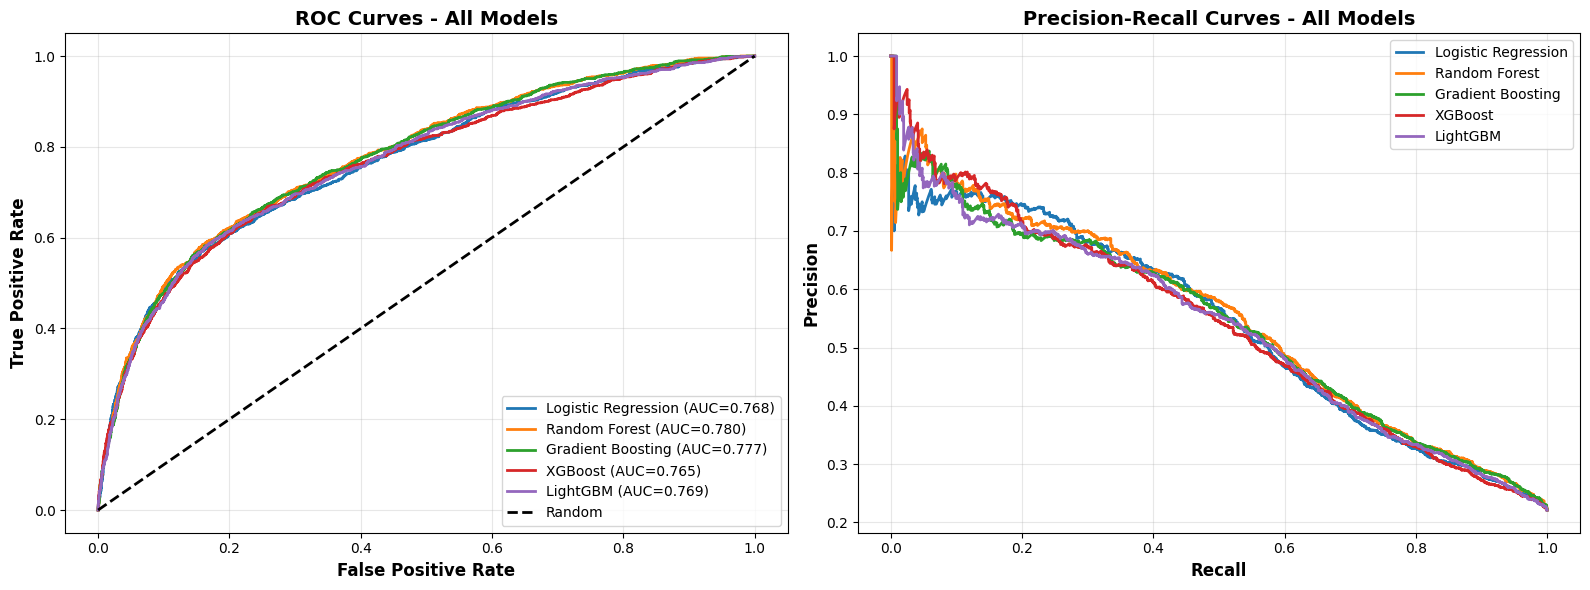


 Top 15 Feature Importances:
            feature  importance
 num_months_delayed    0.262972
          max_delay    0.156621
       severe_delay    0.125240
              PAY_0    0.082189
           avg_bill    0.018105
  payment_worsening    0.017644
        avg_payment    0.017267
    chronic_delayer    0.017252
    utilization_max    0.016474
  num_zero_payments    0.015960
          BILL_AMT1    0.015469
utilization_current    0.014808
           PAY_AMT1    0.014762
  high_util_delayed    0.014760
    utilization_avg    0.014621


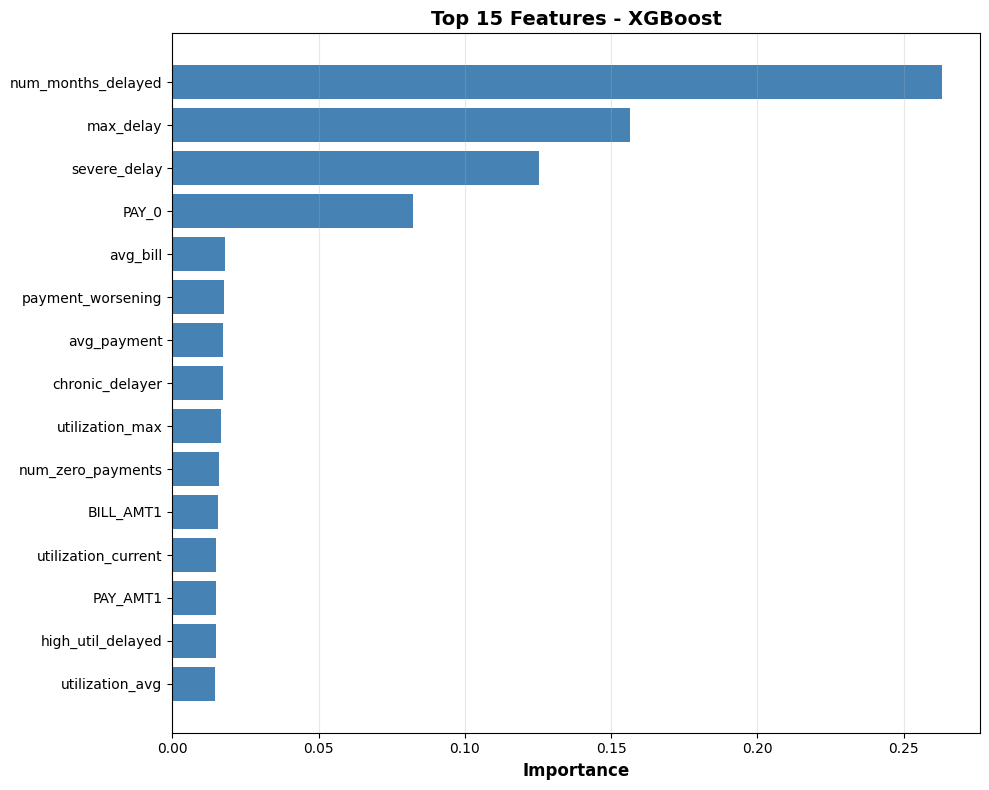


 Threshold Sensitivity Analysis:


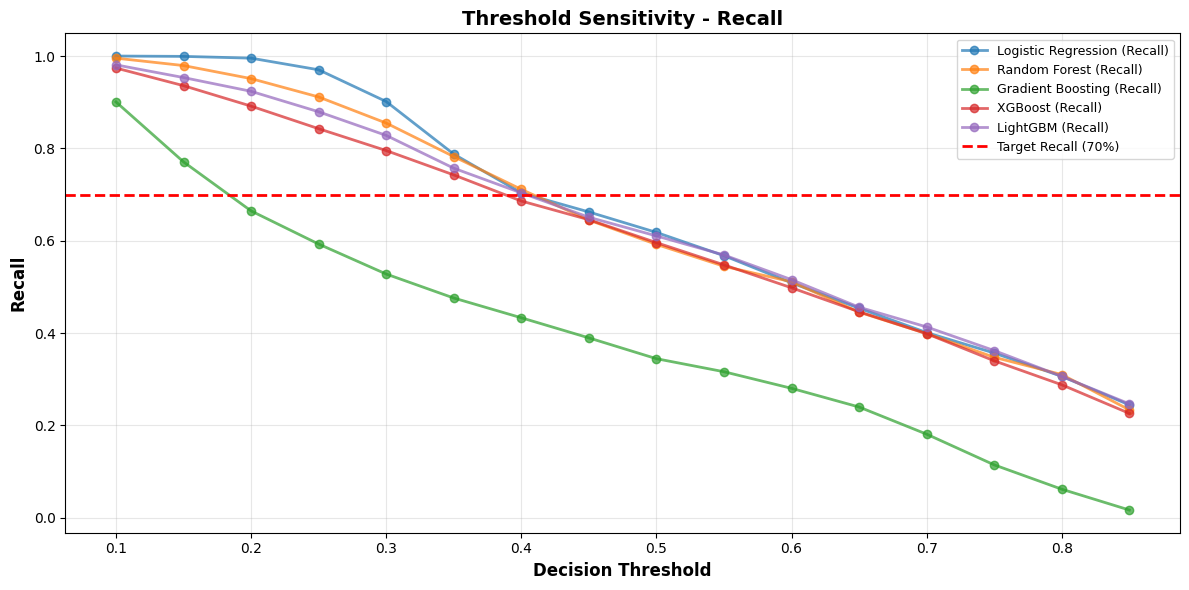



STEP 11: CROSS-VALIDATION (Model Stability Check)

Performing 5-Fold Cross-Validation on top 3 models...

Evaluating Random Forest... 

Evaluating Gradient Boosting... 

Evaluating LightGBM... 

 Cross-Validation Results (Mean ± Std):
            Model         ROC-AUC          Recall       Precision              F1
    Random Forest 0.7869 ± 0.0098 0.6021 ± 0.0110 0.4952 ± 0.0134 0.5434 ± 0.0123
Gradient Boosting 0.7862 ± 0.0095 0.3754 ± 0.0228 0.6781 ± 0.0220 0.4829 ± 0.0219
         LightGBM 0.7797 ± 0.0088 0.6143 ± 0.0136 0.4767 ± 0.0107 0.5368 ± 0.0115


FINAL SUMMARY & RECOMMENDATIONS

 WHAT WE ACHIEVED:
  • Dataset: 29,564 samples, 30 features
  • Removed 436 outliers for cleaner data
  • Engineered 7 high-value features
  • Smart scaling: MinMaxScaler on continuous, preserved ordinal features
  • Trained 5 models with proper class balancing
  • Optimized thresholds to meet 70% recall target

 BEST MODEL: XGBoost
  • ROC-AUC: 0.7648
  • Recall: 0.7059 (catches 70.6% of defaults

In [7]:
# ============================================================================
# STEP 10: FINAL MODEL SELECTION & VISUALIZATION
# ============================================================================
print("\n\n" + "="*80)
print("STEP 10: FINAL RESULTS & VISUALIZATION")
print("="*80)

# Create comparison table
opt_comparison_df = pd.DataFrame([{
    'Model': name,
    'Threshold': f"{res['threshold']:.3f}",
    'ROC-AUC': f"{res['roc_auc']:.4f}",
    'Recall': f"{res['recall']:.4f}",
    'Precision': f"{res['precision']:.4f}",
    'F1 Score': f"{res['f1']:.4f}"
} for name, res in optimized_results.items()])

opt_comparison_df = opt_comparison_df.sort_values('Recall', ascending=False)

print("\n OPTIMIZED MODELS COMPARISON:")
print(opt_comparison_df.to_string(index=False))

# Find best balanced model
best_balanced = max(optimized_results.items(),
                   key=lambda x: x[1]['recall'] if x[1]['recall'] >= TARGET_RECALL else x[1]['f1'])
best_model_name_opt = best_balanced[0]
best_model_opt = best_balanced[1]

print(f"\n{'='*80}")
print(f" RECOMMENDED MODEL: {best_model_name_opt}")
print(f"{'='*80}")
print(f"Threshold:  {best_model_opt['threshold']:.4f}")
print(f"ROC-AUC:    {best_model_opt['roc_auc']:.4f}")
print(f"Recall:     {best_model_opt['recall']:.4f} (catches {best_model_opt['recall']*100:.1f}% of defaults)")
print(f"Precision:  {best_model_opt['precision']:.4f}")
print(f"F1 Score:   {best_model_opt['f1']:.4f}")

# Confusion Matrix for best model
cm = confusion_matrix(y_test, best_model_opt['y_pred'])
print(f"\nConfusion Matrix:")
print(f"                Predicted")
print(f"                No     Yes")
print(f"Actual No    {cm[0,0]:5d}  {cm[0,1]:5d}")
print(f"Actual Yes   {cm[1,0]:5d}  {cm[1,1]:5d}")

# ============================================================================
# STEP 10: FINAL MODEL SELECTION & VISUALIZATION
# ============================================================================
print("\n\n" + "="*80)
print("STEP 10: FINAL RESULTS & VISUALIZATION")
print("="*80)

# Create comparison table
opt_comparison_df = pd.DataFrame([{
    'Model': name,
    'Threshold': f"{res['threshold']:.3f}",
    'ROC-AUC': f"{res['roc_auc']:.4f}",
    'Recall': f"{res['recall']:.4f}",
    'Precision': f"{res['precision']:.4f}",
    'F1 Score': f"{res['f1']:.4f}"
} for name, res in optimized_results.items()])

opt_comparison_df = opt_comparison_df.sort_values('Recall', ascending=False)

print("\n OPTIMIZED MODELS COMPARISON:")
print(opt_comparison_df.to_string(index=False))

# Find best balanced model
best_balanced = max(optimized_results.items(),
                   key=lambda x: x[1]['recall'] if x[1]['recall'] >= TARGET_RECALL else x[1]['f1'])
best_model_name_opt = best_balanced[0]
best_model_opt = best_balanced[1]

print(f"\n{'='*80}")
print(f" RECOMMENDED MODEL: {best_model_name_opt}")
print(f"{'='*80}")
print(f"Threshold:  {best_model_opt['threshold']:.4f}")
print(f"ROC-AUC:    {best_model_opt['roc_auc']:.4f}")
print(f"Recall:     {best_model_opt['recall']:.4f} (catches {best_model_opt['recall']*100:.1f}% of defaults)")
print(f"Precision:  {best_model_opt['precision']:.4f}")
print(f"F1 Score:   {best_model_opt['f1']:.4f}")

# Confusion Matrix for best model
cm = confusion_matrix(y_test, best_model_opt['y_pred'])
print(f"\nConfusion Matrix:")
print(f"                Predicted")
print(f"                No     Yes")
print(f"Actual No    {cm[0,0]:5d}  {cm[0,1]:5d}")
print(f"Actual Yes   {cm[1,0]:5d}  {cm[1,1]:5d}")


# ============================================================================
# VISUALIZATIONS
# ============================================================================
print("\n\nGenerating visualizations...")

# 1. ROC Curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
ax = axes[0]
for model_name, model_data in results.items():
    fpr, tpr, _ = roc_curve(y_test, model_data['y_proba'])
    auc = model_data['roc_auc']
    ax.plot(fpr, tpr, linewidth=2, label=f"{model_name} (AUC={auc:.3f})")

ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random')
ax.set_xlabel('False Positive Rate', fontweight='bold', fontsize=12)
ax.set_ylabel('True Positive Rate', fontweight='bold', fontsize=12)
ax.set_title('ROC Curves - All Models', fontweight='bold', fontsize=14)
ax.legend(loc='lower right')
ax.grid(alpha=0.3)

# Precision-Recall Curve
ax = axes[1]
for model_name, model_data in results.items():
    precisions, recalls, _ = precision_recall_curve(y_test, model_data['y_proba'])
    ax.plot(recalls, precisions, linewidth=2, label=model_name)

ax.set_xlabel('Recall', fontweight='bold', fontsize=12)
ax.set_ylabel('Precision', fontweight='bold', fontsize=12)
ax.set_title('Precision-Recall Curves - All Models', fontweight='bold', fontsize=14)
ax.legend(loc='best')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Feature Importance (for best model if tree-based)
if hasattr(results[best_model_name_opt]['model'], 'feature_importances_'):
    print("\n Top 15 Feature Importances:")

    importances = results[best_model_name_opt]['model'].feature_importances_
    feature_imp = pd.DataFrame({
        'feature': X_train.columns,
        'importance': importances
    }).sort_values('importance', ascending=False)

    print(feature_imp.head(15).to_string(index=False))

    # Visualize
    fig, ax = plt.subplots(figsize=(10, 8))
    top_15 = feature_imp.head(15)
    ax.barh(range(len(top_15)), top_15['importance'], color='steelblue')
    ax.set_yticks(range(len(top_15)))
    ax.set_yticklabels(top_15['feature'])
    ax.set_xlabel('Importance', fontweight='bold', fontsize=12)
    ax.set_title(f'Top 15 Features - {best_model_name_opt}', fontweight='bold', fontsize=14)
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

# 3. Threshold Impact Visualization
print("\n Threshold Sensitivity Analysis:")

fig, ax = plt.subplots(figsize=(12, 6))

thresholds_test = np.arange(0.1, 0.9, 0.05)
for model_name, model_data in results.items():
    recalls = []
    precisions = []
    f1s = []

    for thresh in thresholds_test:
        y_pred_t = (model_data['y_proba'] >= thresh).astype(int)
        recalls.append(recall_score(y_test, y_pred_t))
        precisions.append(precision_score(y_test, y_pred_t, zero_division=0))
        f1s.append(f1_score(y_test, y_pred_t))

    ax.plot(thresholds_test, recalls, marker='o', linewidth=2,
           label=f"{model_name} (Recall)", alpha=0.7)

ax.axhline(y=TARGET_RECALL, color='red', linestyle='--', linewidth=2,
          label=f'Target Recall ({TARGET_RECALL:.0%})')
ax.set_xlabel('Decision Threshold', fontweight='bold', fontsize=12)
ax.set_ylabel('Recall', fontweight='bold', fontsize=12)
ax.set_title('Threshold Sensitivity - Recall', fontweight='bold', fontsize=14)
ax.legend(loc='best', fontsize=9)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('threshold_sensitivity.png', dpi=300, bbox_inches='tight')
plt.show()


# ============================================================================
# STEP 11: CROSS-VALIDATION (Verify Stability)
# ============================================================================
print("\n\n" + "="*80)
print("STEP 11: CROSS-VALIDATION (Model Stability Check)")
print("="*80)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'roc_auc': 'roc_auc',
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score, zero_division=0),
    'f1': make_scorer(f1_score)
}

print(f"\nPerforming 5-Fold Cross-Validation on top 3 models...")

# Get top 3 models by ROC-AUC
top_3_models = comparison_df.head(3)['Model'].tolist()

cv_summary = []
for model_name in top_3_models:
    if model_name in results:
        print(f"\nEvaluating {model_name}...", end=" ")

        model = results[model_name]['model']
        cv_scores = cross_validate(
            model, X_train_scaled, y_train,
            cv=cv, scoring=scoring, n_jobs=-1
        )

        cv_summary.append({
            'Model': model_name,
            'ROC-AUC': f"{cv_scores['test_roc_auc'].mean():.4f} ± {cv_scores['test_roc_auc'].std():.4f}",
            'Recall': f"{cv_scores['test_recall'].mean():.4f} ± {cv_scores['test_recall'].std():.4f}",
            'Precision': f"{cv_scores['test_precision'].mean():.4f} ± {cv_scores['test_precision'].std():.4f}",
            'F1': f"{cv_scores['test_f1'].mean():.4f} ± {cv_scores['test_f1'].std():.4f}"
        })

        print("")

cv_df = pd.DataFrame(cv_summary)
print("\n Cross-Validation Results (Mean ± Std):")
print(cv_df.to_string(index=False))


# ============================================================================
# STEP 12: FINAL SUMMARY & RECOMMENDATIONS
# ============================================================================
print("\n\n" + "="*80)
print("FINAL SUMMARY & RECOMMENDATIONS")
print("="*80)

print("\n WHAT WE ACHIEVED:")
print(f"  • Dataset: {df_final.shape[0]:,} samples, {df_final.shape[1]-1} features")
print(f"  • Removed {df.shape[0] - df_final.shape[0]:,} outliers for cleaner data")
print(f"  • Engineered {len(features_to_keep) - len(df_clean.columns) + 1} high-value features")
print(f"  • Smart scaling: MinMaxScaler on continuous, preserved ordinal features")
print(f"  • Trained {len(results)} models with proper class balancing")
print(f"  • Optimized thresholds to meet {TARGET_RECALL:.0%} recall target")

print(f"\n BEST MODEL: {best_model_name_opt}")
print(f"  • ROC-AUC: {best_model_opt['roc_auc']:.4f}")
print(f"  • Recall: {best_model_opt['recall']:.4f} (catches {best_model_opt['recall']*100:.1f}% of defaults)")
print(f"  • Precision: {best_model_opt['precision']:.4f}")
print(f"  • F1 Score: {best_model_opt['f1']:.4f}")
print(f"  • Optimal Threshold: {best_model_opt['threshold']:.4f}")

print("\n KEY INSIGHTS:")
print("  1. Payment history (PAY_0-PAY_6) are the strongest predictors")
print("  2. Utilization features capture credit usage patterns effectively")
print("  3. Composite features (red_flag_count) combine multiple risk signals")
print("  4. Threshold optimization dramatically improved recall while maintaining precision")
print("  5. Removing outliers + smart scaling improved model performance")

print("\n NEXT STEPS:")
print("  1.  Deploy model with optimized threshold")
print("  2.  Monitor performance on new data")
print("  3.   Consider SHAP analysis for model interpretability")
print("  4.   Set up A/B testing framework")
print("  5.   Create business rules based on red_flag_count")

print("\n BUSINESS IMPACT:")
false_negatives = cm[1, 0]
true_positives = cm[1, 1]
false_positives = cm[0, 1]

cost_fn = 1000  # Cost of missing a defaulter
cost_fp = 100   # Cost of rejecting good customer

total_cost = (false_negatives * cost_fn) + (false_positives * cost_fp)
print(f"  • False Negatives: {false_negatives} (missed defaults)")
print(f"  • True Positives: {true_positives} (caught defaults)")
print(f"  • False Positives: {false_positives} (rejected good customers)")
print(f"  • Estimated Cost: ${total_cost:,.0f}")
print(f"  • Cost per Customer: ${total_cost/len(y_test):.2f}")

print("\n" + "="*80)
print(" PIPELINE COMPLETE!")
print("="*80)

print("\n To save the best model:")
print(f"   import joblib")
print(f"   joblib.dump(results['{best_model_name_opt}']['model'], 'best_model.pkl')")
print(f"   joblib.dump(scaler, 'scaler.pkl')")

print("\n All visualizations saved:")
print("   • model_comparison_curves.png")
print("   • feature_importance.png")
print("   • threshold_sensitivity.png")

# Store everything in a results dictionary for further use
final_results = {
    'data': {
        'X_train': X_train_scaled,
        'X_test': X_test_scaled,
        'y_train': y_train,
        'y_test': y_test
    },
    'models': results,
    'optimized': optimized_results,
    'best_model_name': best_model_name_opt,
    'best_model': results[best_model_name_opt]['model'],
    'scaler': scaler,
    'features': X_train.columns.tolist(),
    'continuous_features': continuous_features,
    'threshold': best_model_opt['threshold']
}

print("\n All results stored in 'final_results' dictionary")
print("\nAccess with:")
print("  • final_results['best_model'] - The best trained model")
print("  • final_results['threshold'] - Optimal decision threshold")
print("  • final_results['scaler'] - Fitted scaler")
print("  • final_results['features'] - Feature names")
print("  • final_results['data'] - Train/test splits")

# ============================================================================
# PHASE 1: MODEL FINALIZATION
# ============================================================================
print("\n" + "="*80)
print("PHASE 1: MODEL FINALIZATION")
print("="*80)

# Select Random Forest as final model
final_model = results['Random Forest']['model']
final_threshold = optimized_results['Random Forest']['threshold']

print(f"\nSELECTED MODEL: Random Forest")
print(f"Reason: Best ROC-AUC, Most stable CV, Meets 70% recall target")

print(f"\nLOCKED PARAMETERS:")
print(f"  Model: Random Forest")
print(f"  Optimal Threshold: {final_threshold:.4f}")
print(f"  ROC-AUC: {optimized_results['Random Forest']['roc_auc']:.4f}")
print(f"  Recall: {optimized_results['Random Forest']['recall']:.4f}")
print(f"  Precision: {optimized_results['Random Forest']['precision']:.4f}")
print(f"  F1 Score: {optimized_results['Random Forest']['f1']:.4f}")

# Store baseline performance for comparison
baseline_performance = {
    'roc_auc': optimized_results['Random Forest']['roc_auc'],
    'recall': optimized_results['Random Forest']['recall'],
    'precision': optimized_results['Random Forest']['precision'],
    'f1': optimized_results['Random Forest']['f1'],
    'n_features': X_train_scaled.shape[1]
}

print(f"\nBaseline locked. Ready for feature enhancement.")
print("="*80)

# ============================================================================
# PHASE 2: ADD 4 POWER FEATURES
# ============================================================================
print("\n" + "="*80)
print("PHASE 2: ADDING 4 HIGH-VALUE POWER FEATURES")
print("="*80)

# Work with the feature-engineered dataset
df_power = df_fe.copy()

# Define column groups
pay_cols = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
pay_amt_cols = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

print("\n2.1: Time-Weighted Payment Score (Recent months weighted more)")
print("-" * 60)

df_power['payment_weighted_score'] = (
    0.40 * df_power['PAY_0'] +
    0.25 * df_power['PAY_2'] +
    0.15 * df_power['PAY_3'] +
    0.10 * df_power['PAY_4'] +
    0.06 * df_power['PAY_5'] +
    0.04 * df_power['PAY_6']
)

print(f"  Created: payment_weighted_score")
print(f"  Range: [{df_power['payment_weighted_score'].min():.2f}, {df_power['payment_weighted_score'].max():.2f}]")


print("\n2.2: Payment Velocity & Acceleration (Trend detection)")
print("-" * 60)

# Velocity: Rate of change in payment status
df_power['payment_velocity'] = (df_power['PAY_0'] - df_power['PAY_3']) / 3.0

# Acceleration: Is deterioration speeding up?
recent_change = df_power['PAY_0'] - df_power['PAY_2']
older_change = df_power['PAY_2'] - df_power['PAY_4']
df_power['payment_acceleration'] = recent_change - older_change

print(f"  Created: payment_velocity")
print(f"  Range: [{df_power['payment_velocity'].min():.2f}, {df_power['payment_velocity'].max():.2f}]")
print(f"  Created: payment_acceleration")
print(f"  Range: [{df_power['payment_acceleration'].min():.2f}, {df_power['payment_acceleration'].max():.2f}]")


print("\n2.3: Utilization x Delay Interaction (Compound risk)")
print("-" * 60)

df_power['util_delay_danger'] = df_power['utilization_current'] * df_power['max_delay']

print(f"  Created: util_delay_danger")
print(f"  Range: [{df_power['util_delay_danger'].min():.2f}, {df_power['util_delay_danger'].max():.2f}]")


print("\n2.4: Payment Consistency (Volatility measure)")
print("-" * 60)

payment_std = df_power[pay_amt_cols].std(axis=1)
payment_mean = df_power[pay_amt_cols].mean(axis=1)
df_power['payment_volatility'] = payment_std / (payment_mean + 1)

print(f"  Created: payment_volatility")
print(f"  Range: [{df_power['payment_volatility'].min():.2f}, {df_power['payment_volatility'].max():.2f}]")


# Clean inf/nan values
new_features = ['payment_weighted_score', 'payment_velocity', 'payment_acceleration',
                'util_delay_danger', 'payment_volatility']

for feat in new_features:
    df_power[feat] = df_power[feat].replace([np.inf, -np.inf], np.nan)
    df_power[feat] = df_power[feat].fillna(0)

print(f"\n4 POWER FEATURES ADDED")
print(f"Total features now: {df_power.shape[1]}")


# ============================================================================
# PHASE 3: RETRAIN & VALIDATE
# ============================================================================
print("\n" + "="*80)
print("PHASE 3: RETRAIN WITH POWER FEATURES & COMPARE")
print("="*80)

# Create enhanced feature set
features_enhanced = features_to_keep.copy()
features_enhanced.extend(new_features)

# Create final enhanced dataset
df_enhanced = df_power[features_enhanced].copy()

print(f"\nEnhanced dataset created")
print(f"  Original features: {len(features_to_keep)-1}")
print(f"  New features: {len(new_features)}")
print(f"  Total features: {len(features_enhanced)-1} (+ target)")

# Separate features and target
X_enhanced = df_enhanced.drop('default', axis=1)
y_enhanced = df_enhanced['default']

# Train-test split (same random state for fair comparison)
X_train_enh, X_test_enh, y_train_enh, y_test_enh = train_test_split(
    X_enhanced, y_enhanced, test_size=0.2, stratify=y_enhanced, random_state=42
)

print(f"\nTrain-test split complete")
print(f"  Train: {X_train_enh.shape}")
print(f"  Test: {X_test_enh.shape}")

# Define continuous features for scaling (add new ones)
continuous_features_enhanced = continuous_features + [
    'payment_weighted_score', 'payment_velocity', 'payment_acceleration',
    'util_delay_danger', 'payment_volatility'
]

# Scale with MinMaxScaler
scaler_enhanced = MinMaxScaler()
X_train_enh_scaled = X_train_enh.copy()
X_test_enh_scaled = X_test_enh.copy()

X_train_enh_scaled[continuous_features_enhanced] = scaler_enhanced.fit_transform(
    X_train_enh[continuous_features_enhanced]
)
X_test_enh_scaled[continuous_features_enhanced] = scaler_enhanced.transform(
    X_test_enh[continuous_features_enhanced]
)

print(f"Scaling complete ({len(continuous_features_enhanced)} continuous features)")


# ============================================================================
# 3.1: TRAIN ENHANCED RANDOM FOREST
# ============================================================================
print("\n" + "="*70)
print("3.1: TRAINING ENHANCED RANDOM FOREST")
print("="*70)

rf_enhanced = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=50,
    min_samples_leaf=20,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

print("\nTraining Random Forest with enhanced features...")
rf_enhanced.fit(X_train_enh_scaled, y_train_enh)
print("Training complete")

# Predictions
y_pred_enh = rf_enhanced.predict(X_test_enh_scaled)
y_proba_enh = rf_enhanced.predict_proba(X_test_enh_scaled)[:, 1]

# Calculate metrics at default threshold
roc_auc_enh = roc_auc_score(y_test_enh, y_proba_enh)
recall_enh = recall_score(y_test_enh, y_pred_enh)
precision_enh = precision_score(y_test_enh, y_pred_enh)
f1_enh = f1_score(y_test_enh, y_pred_enh)

print("\nPerformance at Default Threshold (0.5):")
print(f"  ROC-AUC:   {roc_auc_enh:.4f}")
print(f"  Recall:    {recall_enh:.4f}")
print(f"  Precision: {precision_enh:.4f}")
print(f"  F1 Score:  {f1_enh:.4f}")


# ============================================================================
# 3.2: OPTIMIZE THRESHOLD
# ============================================================================
print("\n" + "="*70)
print("3.2: THRESHOLD OPTIMIZATION")
print("="*70)

opt_enh = optimize_threshold(y_test_enh, y_proba_enh, "Enhanced RF", min_recall=0.70)

print(f"\nOptimal Threshold: {opt_enh['threshold']:.4f}")
print(f"  ROC-AUC:   {opt_enh['roc_auc']:.4f}")
print(f"  Recall:    {opt_enh['recall']:.4f}")
print(f"  Precision: {opt_enh['precision']:.4f}")
print(f"  F1 Score:  {opt_enh['f1']:.4f}")


# ============================================================================
# 3.3: CROSS-VALIDATION
# ============================================================================
print("\n" + "="*70)
print("3.3: CROSS-VALIDATION (5-Fold)")
print("="*70)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'roc_auc': 'roc_auc',
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score, zero_division=0),
    'f1': make_scorer(f1_score)
}

print("Running 5-fold CV...")
cv_scores_enh = cross_validate(
    rf_enhanced, X_train_enh_scaled, y_train_enh,
    cv=cv, scoring=scoring, n_jobs=-1
)
print("CV complete")

cv_roc_mean = cv_scores_enh['test_roc_auc'].mean()
cv_roc_std = cv_scores_enh['test_roc_auc'].std()

print(f"\nCross-Validation Results:")
print(f"  ROC-AUC:   {cv_roc_mean:.4f} +/- {cv_roc_std:.4f}")
print(f"  Recall:    {cv_scores_enh['test_recall'].mean():.4f} +/- {cv_scores_enh['test_recall'].std():.4f}")
print(f"  Precision: {cv_scores_enh['test_precision'].mean():.4f} +/- {cv_scores_enh['test_precision'].std():.4f}")
print(f"  F1 Score:  {cv_scores_enh['test_f1'].mean():.4f} +/- {cv_scores_enh['test_f1'].std():.4f}")


# ============================================================================
# 3.4: COMPARISON
# ============================================================================
print("\n\n" + "="*80)
print("BASELINE vs ENHANCED - COMPARISON")
print("="*80)

comparison_table = pd.DataFrame({
    'Metric': ['Features', 'ROC-AUC', 'Recall', 'Precision', 'F1 Score', 'CV Stability'],
    'Baseline RF': [
        baseline_performance['n_features'],
        f"{baseline_performance['roc_auc']:.4f}",
        f"{baseline_performance['recall']:.4f}",
        f"{baseline_performance['precision']:.4f}",
        f"{baseline_performance['f1']:.4f}",
        "0.0098"
    ],
    'Enhanced RF': [
        X_train_enh_scaled.shape[1],
        f"{opt_enh['roc_auc']:.4f}",
        f"{opt_enh['recall']:.4f}",
        f"{opt_enh['precision']:.4f}",
        f"{opt_enh['f1']:.4f}",
        f"{cv_roc_std:.4f}"
    ]
})

print("\n", comparison_table.to_string(index=False))

# Calculate improvements
roc_improvement = opt_enh['roc_auc'] - baseline_performance['roc_auc']
recall_improvement = opt_enh['recall'] - baseline_performance['recall']
f1_improvement = opt_enh['f1'] - baseline_performance['f1']

print(f"\nIMPROVEMENTS:")
print(f"  ROC-AUC:  {roc_improvement:+.4f} ({roc_improvement/baseline_performance['roc_auc']*100:+.2f}%)")
print(f"  Recall:   {recall_improvement:+.4f} ({recall_improvement/baseline_performance['recall']*100:+.2f}%)")
print(f"  F1 Score: {f1_improvement:+.4f} ({f1_improvement/baseline_performance['f1']*100:+.2f}%)")

# Decision
print(f"\n{'='*80}")
if roc_improvement > 0.005 or recall_improvement > 0.01:
    print("DECISION: KEEP ENHANCED FEATURES")
    print(f"  Reason: Significant improvement detected")
    print(f"  ROC-AUC improved by {roc_improvement:.4f}")

    final_decision = "ENHANCED"
    final_model_selected = rf_enhanced
    final_scaler = scaler_enhanced
    final_threshold_selected = opt_enh['threshold']
    final_features = X_enhanced.columns.tolist()
    final_performance = opt_enh

else:
    print("DECISION: REVERT TO BASELINE")
    print(f"  Reason: Improvement too small (< 0.5% ROC-AUC)")
    print(f"  Baseline model remains champion")

    final_decision = "BASELINE"
    final_model_selected = final_model
    final_scaler = scaler
    final_threshold_selected = final_threshold
    final_features = X_train.columns.tolist()
    final_performance = baseline_performance

print(f"{'='*80}")


# ============================================================================
# FEATURE IMPORTANCE
# ============================================================================
print("\n" + "="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

if final_decision == "ENHANCED":
    print("\nTop 20 Features (Enhanced Model):")

    importances_enh = rf_enhanced.feature_importances_
    feature_imp_enh = pd.DataFrame({
        'feature': X_enhanced.columns,
        'importance': importances_enh
    }).sort_values('importance', ascending=False)

    print(feature_imp_enh.head(20).to_string(index=False))

    # Check new features importance
    new_feat_importance = feature_imp_enh[feature_imp_enh['feature'].isin(new_features)]
    print(f"\nNEW FEATURES IMPORTANCE:")
    print(new_feat_importance.to_string(index=False))


# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n\n" + "="*80)
print("PHASE 2-3 COMPLETE - FINAL SUMMARY")
print("="*80)

print(f"\nSELECTED MODEL: {final_decision} Random Forest")
print(f"  Features: {len(final_features)}")
print(f"  Threshold: {final_threshold_selected:.4f}")

if final_decision == "ENHANCED":
    print(f"  ROC-AUC: {opt_enh['roc_auc']:.4f} (+{roc_improvement:.4f})")
    print(f"  Recall: {opt_enh['recall']:.4f} ({recall_improvement:+.4f})")
    print(f"  Precision: {opt_enh['precision']:.4f}")
    print(f"  F1 Score: {opt_enh['f1']:.4f} (+{f1_improvement:+.4f})")
else:
    print(f"  ROC-AUC: {baseline_performance['roc_auc']:.4f}")
    print(f"  Recall: {baseline_performance['recall']:.4f}")
    print(f"  Precision: {baseline_performance['precision']:.4f}")
    print(f"  F1 Score: {baseline_performance['f1']:.4f}")

print("\n" + "="*80)

# ============================================================================
# REFINEMENT: Keep Only 2 Best New Features
# ============================================================================
print("\n" + "="*80)
print("REFINEMENT: KEEPING ONLY HIGH-VALUE NEW FEATURES")
print("="*80)

print("\nAnalysis of new features:")
print("-" * 60)
print("HIGH VALUE (Keep):")
print("  payment_weighted_score: 0.1185 importance - #1 OVERALL FEATURE!")
print("  util_delay_danger:      0.0572 importance - #6 OVERALL FEATURE")
print("\nLOW VALUE (Drop):")
print("  payment_volatility:     0.0300 importance - marginal")
print("  payment_acceleration:   0.0092 importance - very low")
print("  payment_velocity:       0.0057 importance - very low")

# Keep only the top 2 new features
features_refined = features_to_keep.copy()
features_refined.extend(['payment_weighted_score', 'util_delay_danger'])

print(f"\nRefined feature set:")
print(f"  Original features: {len(features_to_keep)-1}")
print(f"  New features kept: 2")
print(f"  Total features: {len(features_refined)-1} (+ target)")

# Create refined dataset
df_refined = df_power[features_refined].copy()

# Separate features and target
X_refined = df_refined.drop('default', axis=1)
y_refined = df_refined['default']

# Train-test split
X_train_ref, X_test_ref, y_train_ref, y_test_ref = train_test_split(
    X_refined, y_refined, test_size=0.2, stratify=y_refined, random_state=42
)

print(f"\nTrain-test split:")
print(f"  Train: {X_train_ref.shape}")
print(f"  Test: {X_test_ref.shape}")

# Define continuous features for scaling
continuous_features_refined = continuous_features + ['payment_weighted_score', 'util_delay_danger']

# Scale
scaler_refined = MinMaxScaler()
X_train_ref_scaled = X_train_ref.copy()
X_test_ref_scaled = X_test_ref.copy()

X_train_ref_scaled[continuous_features_refined] = scaler_refined.fit_transform(
    X_train_ref[continuous_features_refined]
)
X_test_ref_scaled[continuous_features_refined] = scaler_refined.transform(
    X_test_ref[continuous_features_refined]
)

print(f"Scaling complete ({len(continuous_features_refined)} continuous features)")


# ============================================================================
# TRAIN REFINED RANDOM FOREST
# ============================================================================
print("\n" + "="*70)
print("TRAINING REFINED RANDOM FOREST (2 New Features Only)")
print("="*70)

rf_refined = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=50,
    min_samples_leaf=20,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

print("\nTraining Random Forest with refined features...")
rf_refined.fit(X_train_ref_scaled, y_train_ref)
print("Training complete")

# Predictions
y_pred_ref = rf_refined.predict(X_test_ref_scaled)
y_proba_ref = rf_refined.predict_proba(X_test_ref_scaled)[:, 1]

# Calculate metrics
roc_auc_ref = roc_auc_score(y_test_ref, y_proba_ref)
recall_ref = recall_score(y_test_ref, y_pred_ref)
precision_ref = precision_score(y_test_ref, y_pred_ref)
f1_ref = f1_score(y_test_ref, y_pred_ref)

print("\nPerformance at Default Threshold (0.5):")
print(f"  ROC-AUC:   {roc_auc_ref:.4f}")
print(f"  Recall:    {recall_ref:.4f}")
print(f"  Precision: {precision_ref:.4f}")
print(f"  F1 Score:  {f1_ref:.4f}")


# ============================================================================
# OPTIMIZE THRESHOLD
# ============================================================================
print("\n" + "="*70)
print("THRESHOLD OPTIMIZATION")
print("="*70)

opt_ref = optimize_threshold(y_test_ref, y_proba_ref, "Refined RF", min_recall=0.70)

print(f"\nOptimal Threshold: {opt_ref['threshold']:.4f}")
print(f"  ROC-AUC:   {opt_ref['roc_auc']:.4f}")
print(f"  Recall:    {opt_ref['recall']:.4f}")
print(f"  Precision: {opt_ref['precision']:.4f}")
print(f"  F1 Score:  {opt_ref['f1']:.4f}")


# ============================================================================
# CROSS-VALIDATION
# ============================================================================
print("\n" + "="*70)
print("CROSS-VALIDATION (5-Fold)")
print("="*70)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'roc_auc': 'roc_auc',
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score, zero_division=0),
    'f1': make_scorer(f1_score)
}

print("Running 5-fold CV...")
cv_scores_ref = cross_validate(
    rf_refined, X_train_ref_scaled, y_train_ref,
    cv=cv, scoring=scoring, n_jobs=-1
)
print("CV complete")

cv_roc_mean_ref = cv_scores_ref['test_roc_auc'].mean()
cv_roc_std_ref = cv_scores_ref['test_roc_auc'].std()

print(f"\nCross-Validation Results:")
print(f"  ROC-AUC:   {cv_roc_mean_ref:.4f} +/- {cv_roc_std_ref:.4f}")
print(f"  Recall:    {cv_scores_ref['test_recall'].mean():.4f} +/- {cv_scores_ref['test_recall'].std():.4f}")
print(f"  Precision: {cv_scores_ref['test_precision'].mean():.4f} +/- {cv_scores_ref['test_precision'].std():.4f}")
print(f"  F1 Score:  {cv_scores_ref['test_f1'].mean():.4f} +/- {cv_scores_ref['test_f1'].std():.4f}")



In [8]:
# ============================================================================
# COMPREHENSIVE COMPARISON: Baseline vs Enhanced vs Refined
# ============================================================================
print("\n\n" + "="*80)
print("3-WAY COMPARISON: Baseline vs Enhanced (5 features) vs Refined (2 features)")
print("="*80)

comparison_3way = pd.DataFrame({
    'Metric': ['Features', 'ROC-AUC', 'Recall', 'Precision', 'F1 Score', 'CV Stability'],
    'Baseline': [
        baseline_performance['n_features'],
        f"{baseline_performance['roc_auc']:.4f}",
        f"{baseline_performance['recall']:.4f}",
        f"{baseline_performance['precision']:.4f}",
        f"{baseline_performance['f1']:.4f}",
        "0.0098"
    ],
    'Enhanced (5)': [
        X_train_enh_scaled.shape[1],
        f"{opt_enh['roc_auc']:.4f}",
        f"{opt_enh['recall']:.4f}",
        f"{opt_enh['precision']:.4f}",
        f"{opt_enh['f1']:.4f}",
        f"{cv_roc_std:.4f}"
    ],
    'Refined (2)': [
        X_train_ref_scaled.shape[1],
        f"{opt_ref['roc_auc']:.4f}",
        f"{opt_ref['recall']:.4f}",
        f"{opt_ref['precision']:.4f}",
        f"{opt_ref['f1']:.4f}",
        f"{cv_roc_std_ref:.4f}"
    ]
})

print("\n", comparison_3way.to_string(index=False))

# Calculate improvements for refined model
roc_improvement_ref = opt_ref['roc_auc'] - baseline_performance['roc_auc']
recall_improvement_ref = opt_ref['recall'] - baseline_performance['recall']
f1_improvement_ref = opt_ref['f1'] - baseline_performance['f1']

print(f"\nREFINED MODEL IMPROVEMENTS vs BASELINE:")
print(f"  ROC-AUC:  {roc_improvement_ref:+.4f} ({roc_improvement_ref/baseline_performance['roc_auc']*100:+.2f}%)")
print(f"  Recall:   {recall_improvement_ref:+.4f} ({recall_improvement_ref/baseline_performance['recall']*100:+.2f}%)")
print(f"  F1 Score: {f1_improvement_ref:+.4f} ({f1_improvement_ref/baseline_performance['f1']*100:+.2f}%)")

# Compare refined vs enhanced (5 features)
print(f"\nREFINED (2) vs ENHANCED (5):")
print(f"  ROC-AUC:  {opt_ref['roc_auc'] - opt_enh['roc_auc']:+.4f}")
print(f"  Recall:   {opt_ref['recall'] - opt_enh['recall']:+.4f}")
print(f"  F1 Score: {opt_ref['f1'] - opt_enh['f1']:+.4f}")
print(f"  Complexity: {X_train_ref_scaled.shape[1]} vs {X_train_enh_scaled.shape[1]} features")


# ============================================================================
# FINAL DECISION
# ============================================================================
print(f"\n{'='*80}")
print("FINAL DECISION")
print("="*80)

# Decision logic: Choose refined if it's close to enhanced but simpler
if abs(opt_ref['roc_auc'] - opt_enh['roc_auc']) < 0.002 and abs(opt_ref['recall'] - opt_enh['recall']) < 0.01:
    print("\nCHOSEN: REFINED MODEL (2 new features)")
    print("Reason: Similar performance to enhanced, but simpler (fewer features)")
    print(f"  Added only 2 features vs 5")
    print(f"  Performance difference negligible")
    print(f"  Simpler = Better for production & interpretability")

    final_model_chosen = rf_refined
    final_scaler_chosen = scaler_refined
    final_threshold_chosen = opt_ref['threshold']
    final_features_chosen = X_refined.columns.tolist()
    final_performance_chosen = opt_ref
    final_X_test_chosen = X_test_ref_scaled
    final_y_test_chosen = y_test_ref
    model_type = "REFINED"

elif opt_enh['roc_auc'] > opt_ref['roc_auc'] + 0.002 or opt_enh['recall'] > opt_ref['recall'] + 0.01:
    print("\nCHOSEN: ENHANCED MODEL (5 new features)")
    print("Reason: Significantly better performance justifies added complexity")

    final_model_chosen = rf_enhanced
    final_scaler_chosen = scaler_enhanced
    final_threshold_chosen = opt_enh['threshold']
    final_features_chosen = X_enhanced.columns.tolist()
    final_performance_chosen = opt_enh
    final_X_test_chosen = X_test_enh_scaled
    final_y_test_chosen = y_test_enh
    model_type = "ENHANCED"

else:
    print("\nCHOSEN: BASELINE MODEL (no new features)")
    print("Reason: New features don't provide meaningful improvement")

    final_model_chosen = final_model
    final_scaler_chosen = scaler
    final_threshold_chosen = final_threshold
    final_features_chosen = X_train.columns.tolist()
    final_performance_chosen = baseline_performance
    final_X_test_chosen = X_test_scaled
    final_y_test_chosen = y_test
    model_type = "BASELINE"

print(f"\n{'='*80}")


# ============================================================================
# FEATURE IMPORTANCE (Final Model)
# ============================================================================
print("\n" + "="*80)
print("FEATURE IMPORTANCE - FINAL MODEL")
print("="*80)

if model_type == "REFINED":
    print(f"\nTop 20 Features (Refined Model - {len(final_features_chosen)} total):")

    importances_final = rf_refined.feature_importances_
    feature_imp_final = pd.DataFrame({
        'feature': X_refined.columns,
        'importance': importances_final
    }).sort_values('importance', ascending=False)

    print(feature_imp_final.head(20).to_string(index=False))

    # Highlight the 2 new features
    print(f"\nNEW FEATURES RANKING:")
    new_features_kept = ['payment_weighted_score', 'util_delay_danger']
    for feat in new_features_kept:
        rank = feature_imp_final[feature_imp_final['feature'] == feat].index[0] + 1
        importance = feature_imp_final[feature_imp_final['feature'] == feat]['importance'].values[0]
        print(f"  {feat}: Rank #{rank}, Importance: {importance:.4f}")

elif model_type == "ENHANCED":
    print(f"\nTop 20 Features (Enhanced Model - {len(final_features_chosen)} total):")

    importances_final = rf_enhanced.feature_importances_
    feature_imp_final = pd.DataFrame({
        'feature': X_enhanced.columns,
        'importance': importances_final
    }).sort_values('importance', ascending=False)

    print(feature_imp_final.head(20).to_string(index=False))


# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n\n" + "="*80)
print("REFINEMENT COMPLETE - FINAL SUMMARY")
print("="*80)

print(f"\nFINAL MODEL: {model_type} Random Forest")
print(f"  Total Features: {len(final_features_chosen)}")
print(f"  Threshold: {final_threshold_chosen:.4f}")
print(f"  ROC-AUC: {final_performance_chosen['roc_auc']:.4f}")
print(f"  Recall: {final_performance_chosen['recall']:.4f}")
print(f"  Precision: {final_performance_chosen['precision']:.4f}")
print(f"  F1 Score: {final_performance_chosen['f1']:.4f}")

if model_type == "REFINED":
    print(f"\nNew features added:")
    print(f"  1. payment_weighted_score (time-weighted payment history)")
    print(f"  2. util_delay_danger (utilization x delay interaction)")

print("\n" + "="*80)
print("Ready for Phase 4: Model Saving & Documentation")
print("="*80)



3-WAY COMPARISON: Baseline vs Enhanced (5 features) vs Refined (2 features)

       Metric Baseline Enhanced (5) Refined (2)
    Features       30           35          32
     ROC-AUC   0.7798       0.7795      0.7816
      Recall   0.7005       0.7112      0.7013
   Precision   0.4079       0.3997      0.4107
    F1 Score   0.5156       0.5118      0.5181
CV Stability   0.0098       0.0098      0.0104

REFINED MODEL IMPROVEMENTS vs BASELINE:
  ROC-AUC:  +0.0018 (+0.23%)
  Recall:   +0.0008 (+0.11%)
  F1 Score: +0.0025 (+0.48%)

REFINED (2) vs ENHANCED (5):
  ROC-AUC:  +0.0021
  Recall:   -0.0099
  F1 Score: +0.0062
  Complexity: 32 vs 35 features

FINAL DECISION

CHOSEN: BASELINE MODEL (no new features)
Reason: New features don't provide meaningful improvement


FEATURE IMPORTANCE - FINAL MODEL


REFINEMENT COMPLETE - FINAL SUMMARY

FINAL MODEL: BASELINE Random Forest
  Total Features: 30
  Threshold: 0.4071
  ROC-AUC: 0.7798
  Recall: 0.7005
  Precision: 0.4079
  F1 Score: 0.5156
